In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from AbundanceMatching import *
import emcee
import numpy as np
import Corrfunc
from Corrfunc.theory import wp
from scipy.stats import multivariate_normal
from galaxy_statistics import generate_wp,comp_deconv_steps,AMLikelihood
from astropy.io import fits
import matplotlib
from tqdm import tqdm

## Abundance Matching (SDSS) - M_star < -21,-20, and -18

In [2]:
data_path = '/u/ki/rmredd/data/'
# Luminosity function
# lf_21 = np.loadtxt(data_path + 'lf/tinker/lf_jt_21.dat')
lf_20 = np.loadtxt(data_path + 'lf/tinker/lf_jt_20.dat')
lf_18 = np.loadtxt(data_path + 'lf/tinker/lf_jt_18.dat')
# lf_21 = lf_21[lf_21[:,1]>0,:]
lf_20 = lf_20[lf_20[:,1]>0,:]
lf_18 = lf_18[lf_18[:,1]>0,:]

wp_path = '/u/ki/rmredd/data/corr_wp/tinker_sdss_wp/'
wp_20 = np.loadtxt(wp_path + 'wp_20.dat')
wp_20_cov_temp = np.loadtxt(wp_path + 'wp_covar_20.dat')
wp_20_cov = np.zeros((len(wp_20),len(wp_20)))
for wp_tup in wp_20_cov_temp:
    wp_20_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
    wp_20_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
    
wp_18 = np.loadtxt(wp_path + 'wp_18.dat')
wp_18_cov_temp = np.loadtxt(wp_path + 'wp_covar_18.dat')
wp_18_cov = np.zeros((len(wp_18),len(wp_18)))
for wp_tup in wp_18_cov_temp:
    wp_18_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
    wp_18_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
    
wp_21 = np.loadtxt(wp_path + 'wp_21.dat')
wp_21_cov_temp = np.loadtxt(wp_path + 'wp_covar_21.dat')
wp_21_cov = np.zeros((len(wp_21),len(wp_21)))
for wp_tup in wp_21_cov_temp:
    wp_21_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
    wp_21_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
    
r_cutoff = 15

wp_20_cov=wp_20_cov[wp_20[:,0]<r_cutoff,:]
wp_20_cov=wp_20_cov[:,wp_20[:,0]<r_cutoff]
wp_20_var = np.diag(wp_20_cov)
wp_20 = wp_20[wp_20[:,0]<r_cutoff]

wp_18_cov=wp_18_cov[wp_18[:,0]<r_cutoff,:]
wp_18_cov=wp_18_cov[:,wp_18[:,0]<r_cutoff]
wp_18_var = np.diag(wp_18_cov)
wp_18 = wp_18[wp_18[:,0]<r_cutoff]

wp_21_cov=wp_21_cov[wp_21[:,0]<r_cutoff,:]
wp_21_cov=wp_21_cov[:,wp_21[:,0]<r_cutoff]
wp_21_var = np.diag(wp_21_cov)
wp_21 = wp_21[wp_21[:,0]<r_cutoff]

box_size = 400
pimax = 40.0
scatters = [0.1,0.2,0.3]
deconv_repeat = 200
mag_cuts=[-21.0,-20.0,-18.0]
# Use lf_20 twice since we don't have an lf_21
lf_list = [lf_20,lf_20,lf_18]

# Halos from n body sim
halo_path = '/nfs/slac/des/fs1/g/sims/jderose/BCCSims/c400-2048/'
halos = np.array(fits.open(halo_path + 'hlist_1.00000.list.fits')[1].data)
r_p_data = wp_20[:,0]
wp_data_list = [wp_21[:,0],wp_20[:,0],wp_18[:,0]]
wp_cov_list = [wp_21_cov,wp_20_cov,wp_18_cov]
nthreads = 1

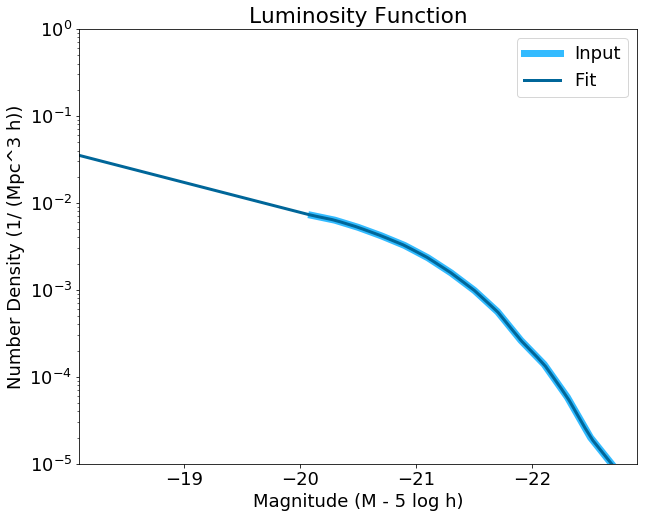

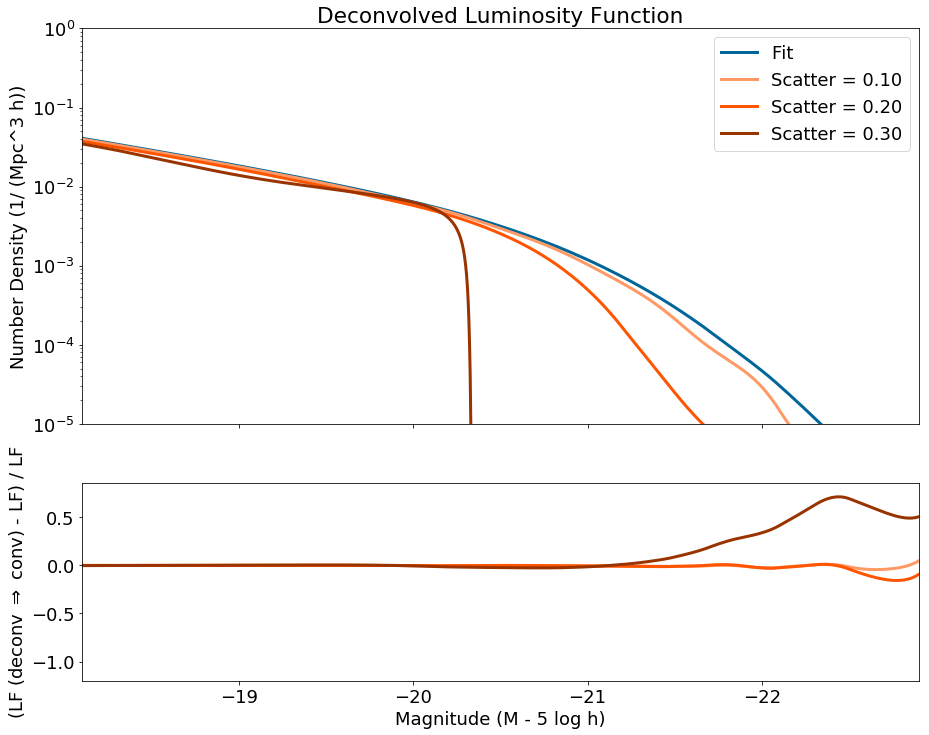

Scatter 0.10 catalog has 75713 galaxies


/u/ki/swagnerc/.local/lib/python3.7/site-packages/Corrfunc-2.3.1-py3.7-linux-x86_64.egg/Corrfunc/utils.py:916: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Scatter 0.20 catalog has 75431 galaxies
Scatter 0.30 catalog has 75014 galaxies


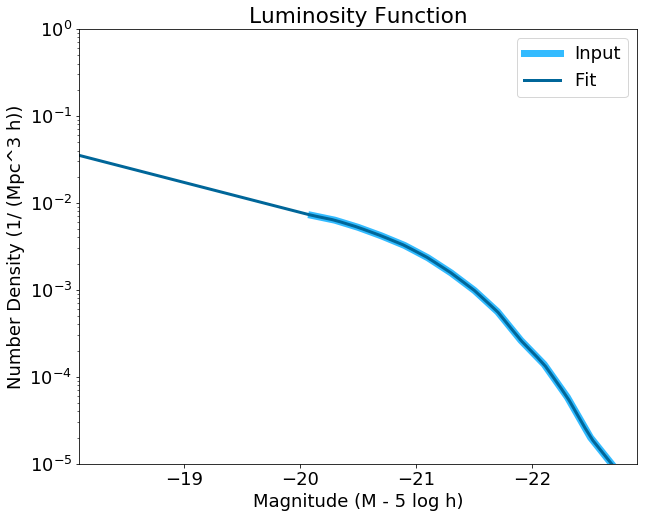

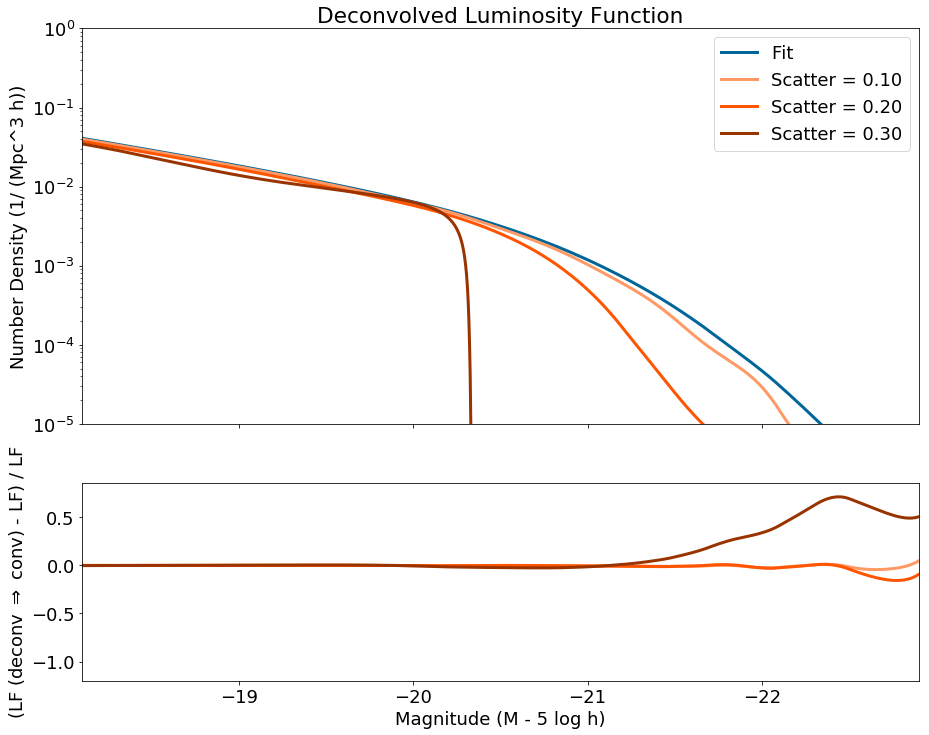

Scatter 0.10 catalog has 409448 galaxies
Scatter 0.20 catalog has 408331 galaxies
Scatter 0.30 catalog has 407893 galaxies


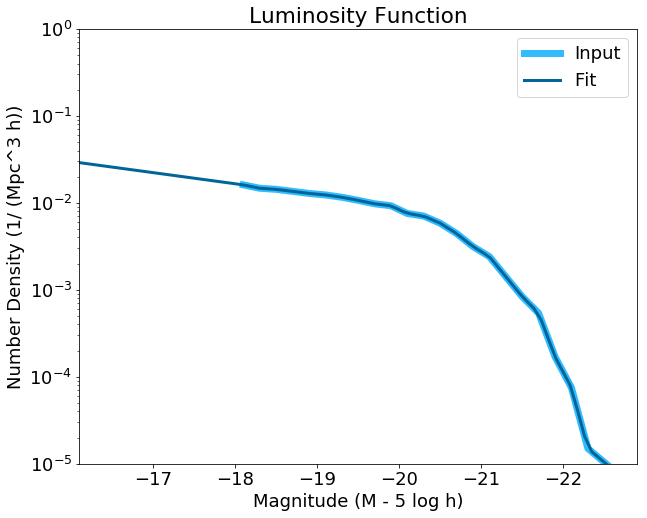

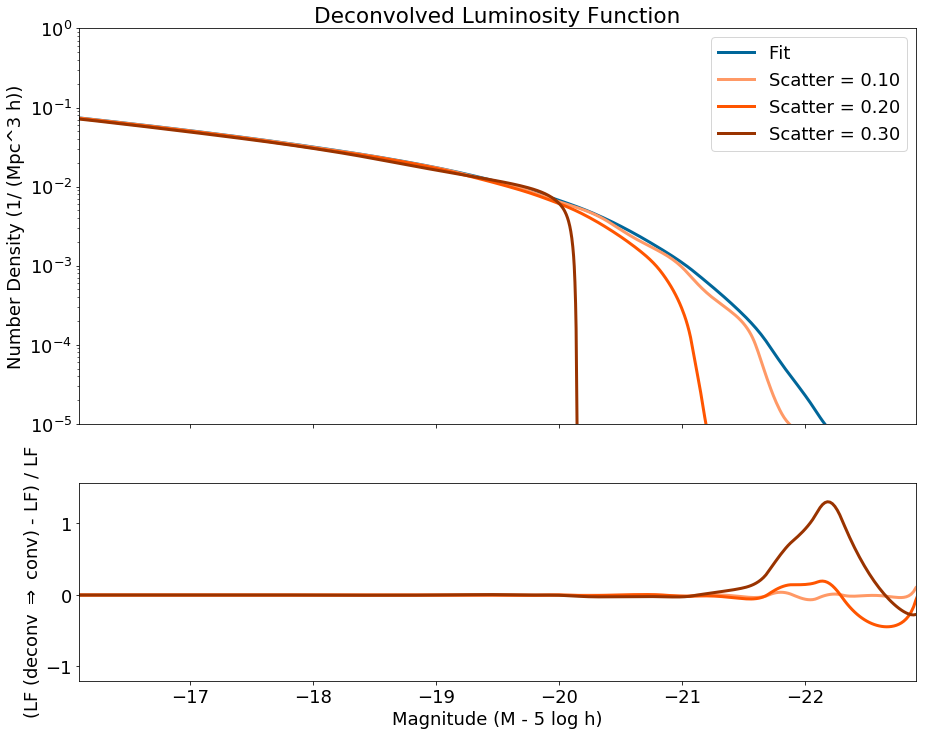

Scatter 0.10 catalog has 2026834 galaxies
Scatter 0.20 catalog has 2027085 galaxies
Scatter 0.30 catalog has 2029004 galaxies


In [4]:
wp_binneds = generate_wp(lf_list,halos,'vmax',wp_20[:,0],box_size,mag_cuts=mag_cuts,pimax=pimax,scatters=scatters,
                    deconv_repeat=deconv_repeat,verbose=True)

chi^2 is -162.907755


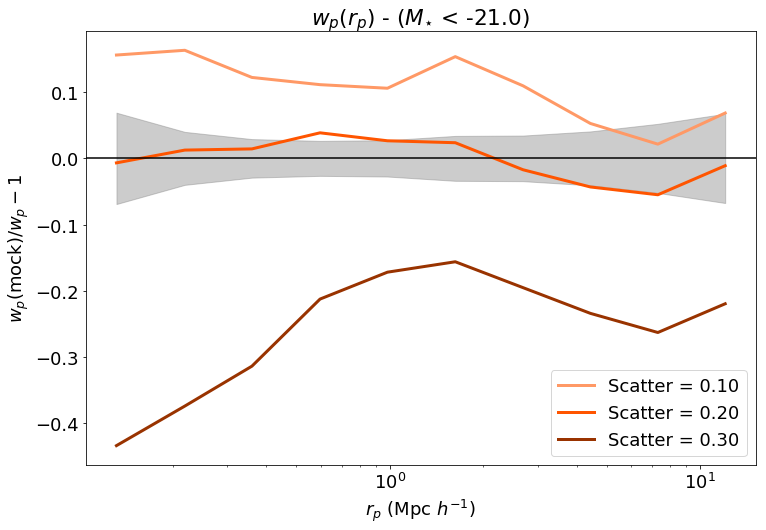

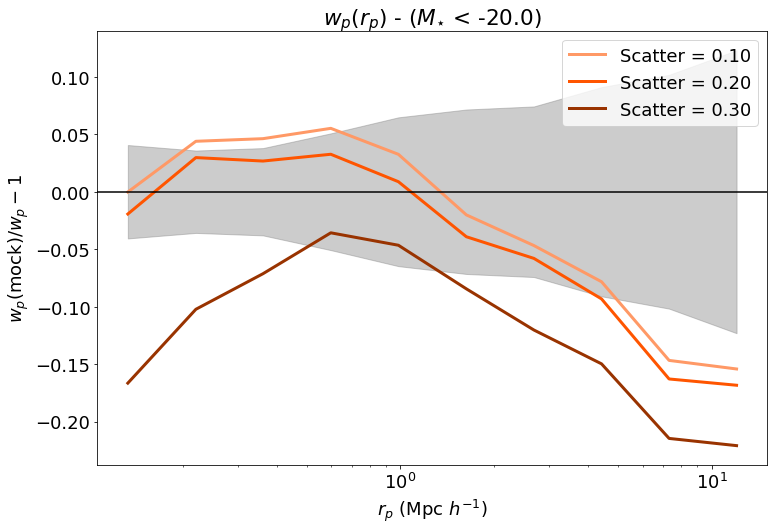

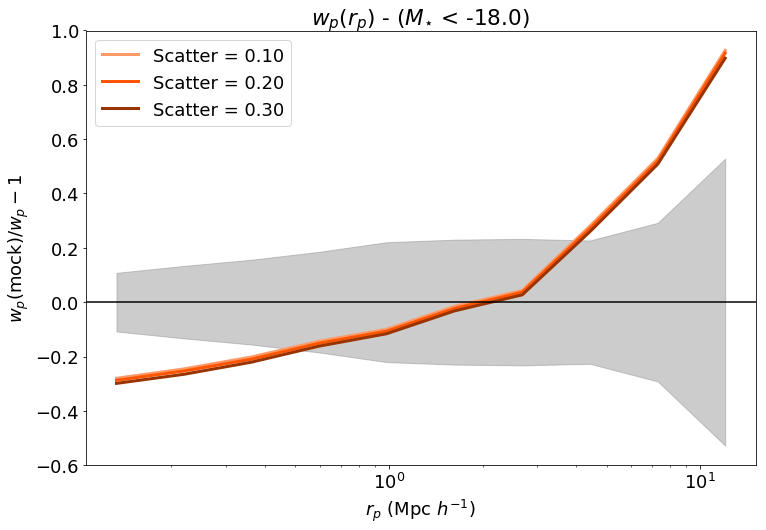

In [5]:
custom_blues_complement = ["#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300","#662200"]

# M_star < -21
plt.figure(figsize=(12,8))
legend = []
for wp_binned in wp_binneds[0]:
    plt.plot(wp_21[:,0],wp_binned/wp_21[:,1]-1,lw=3,c=custom_blues_complement[2*len(legend)])
    legend.append('Scatter = %.2f'%(scatters[len(legend)]))
plt.fill_between(wp_21[:,0],-np.sqrt(wp_21_var)/wp_21[:,1],np.sqrt(wp_21_var)/wp_21[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[0]))
plt.legend(legend)
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.axhline(0,c='k')

# M_star < -20
plt.figure(figsize=(12,8))
legend = []
for wp_binned in wp_binneds[1]:
    plt.plot(wp_20[:,0],wp_binned/wp_20[:,1]-1,lw=3,c=custom_blues_complement[2*len(legend)])
    legend.append('Scatter = %.2f'%(scatters[len(legend)]))
plt.fill_between(wp_20[:,0],-np.sqrt(wp_20_var)/wp_20[:,1],np.sqrt(wp_20_var)/wp_20[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[1]))
plt.legend(legend)
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.axhline(0,c='k')

# M_star < -18
plt.figure(figsize=(12,8))
legend = []
for wp_binned in wp_binneds[2]:
    plt.plot(wp_18[:,0],wp_binned/wp_18[:,1]-1,lw=3,c=custom_blues_complement[2*len(legend)])
    legend.append('Scatter = %.2f'%(scatters[len(legend)]))
plt.fill_between(wp_18[:,0],-np.sqrt(wp_18_var)/wp_18[:,1],np.sqrt(wp_18_var)/wp_18[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[2]))
plt.legend(legend)
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.axhline(0,c='k')

print('chi^2 is %f'%(multivariate_normal.logpdf(wp_binned,wp_20[:,1],wp_20_cov)))

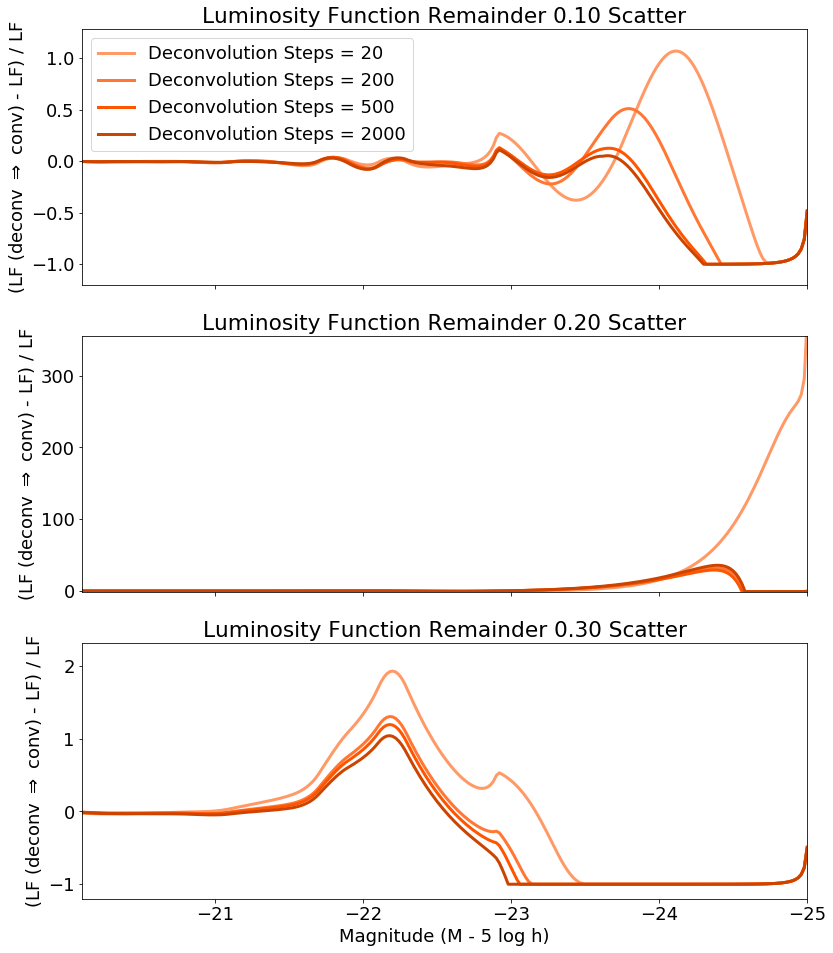

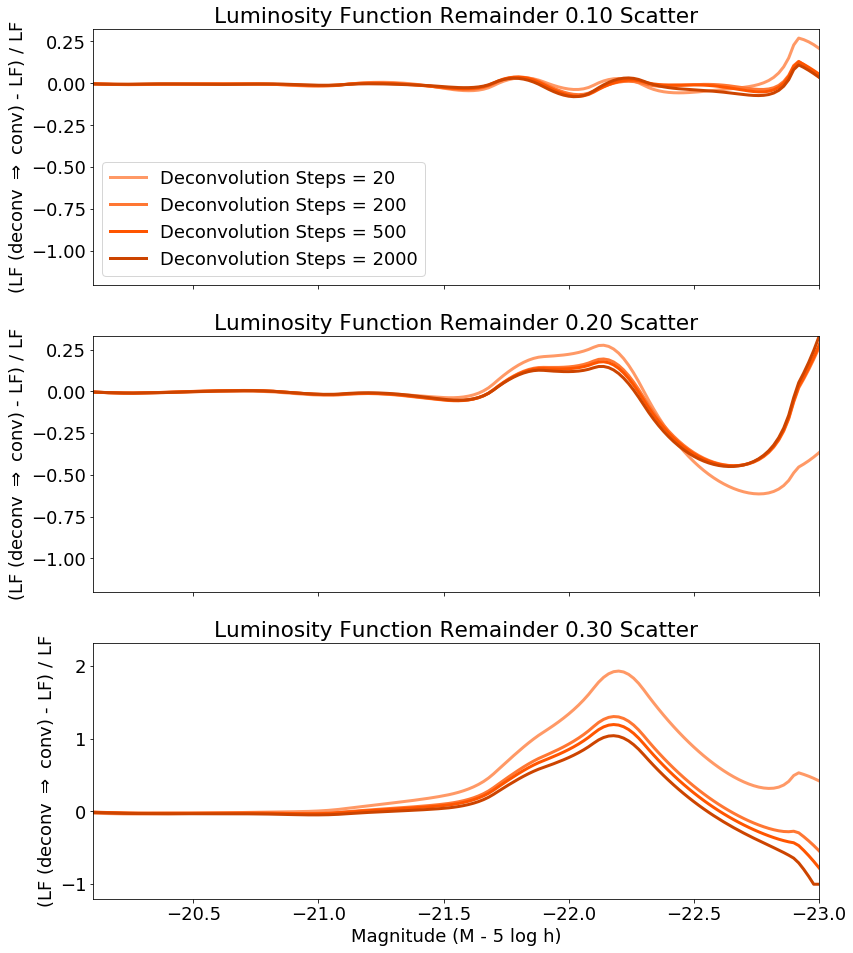

In [39]:
deconv_repeats = [20,200,500,2000]
comp_deconv_steps(lf_18,scatters,deconv_repeats,m_max=-25)
comp_deconv_steps(lf_18,scatters,deconv_repeats,m_max=-23)

### Test that number of deconvolutions can be small

In [3]:
lf_list = [lf_20,lf_20]
wp_data_list = [wp_21[:,1],wp_20[:,1]]
wp_cov_list = [wp_21_cov,wp_20_cov]
wp_save_path = '/u/ki/swagnerc/abundance_matching/wp_results/wp'
like_class_400 = AMLikelihood(lf_list,halos,'vmax',box_size,r_p_data,mag_cuts,wp_data_list,wp_cov_list,pimax,nthreads,
                         400,wp_save_path+'1')
like_class_200 = AMLikelihood(lf_list,halos,'vmax',box_size,r_p_data,mag_cuts,wp_data_list,wp_cov_list,pimax,nthreads,
                         200,wp_save_path+'2')
like_class_20 = AMLikelihood(lf_list,halos,'vmax',box_size,r_p_data,mag_cuts,wp_data_list,wp_cov_list,pimax,nthreads,
                         20,wp_save_path+'3')
like_class_5 = AMLikelihood(lf_list,halos,'vmax',box_size,r_p_data,mag_cuts,wp_data_list,wp_cov_list,pimax,nthreads,
                         5,wp_save_path+'4')

In [4]:
scatter = 0.15
mu_cut = 0.1
import time
start = time.time()
print('Scatter %.2f, mu_cut %.2f, ll %.5f'%(scatter,mu_cut,like_class_400.log_likelihood([scatter,mu_cut],verbose=False)))
print(time.time()-start)

start = time.time()
print('Scatter %.2f, mu_cut %.2f, ll %.5f'%(scatter,mu_cut,like_class_200.log_likelihood([scatter,mu_cut],verbose=False)))
print(time.time()-start)

start = time.time()
print('Scatter %.2f, mu_cut %.2f, ll %.5f'%(scatter,mu_cut,like_class_20.log_likelihood([scatter,mu_cut],verbose=False)))
print(time.time()-start)

start = time.time()
print('Scatter %.2f, mu_cut %.2f, ll %.5f'%(scatter,mu_cut,like_class_5.log_likelihood([scatter,mu_cut],verbose=False)))
print(time.time()-start)

/u/ki/swagnerc/.local/lib/python3.7/site-packages/Corrfunc-2.3.1-py3.7-linux-x86_64.egg/Corrfunc/utils.py:916: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Scatter 0.15, mu_cut 0.10, ll -32.12668
48.85447406768799
Scatter 0.15, mu_cut 0.10, ll -25.49594
31.299119234085083
Scatter 0.15, mu_cut 0.10, ll -21.66233
14.639721155166626
Scatter 0.15, mu_cut 0.10, ll -32.17986
13.20729398727417


[0.15 0.1 ]


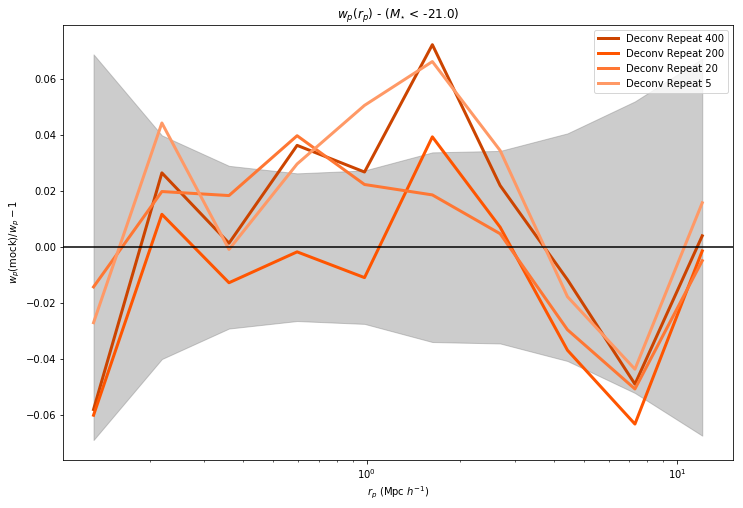

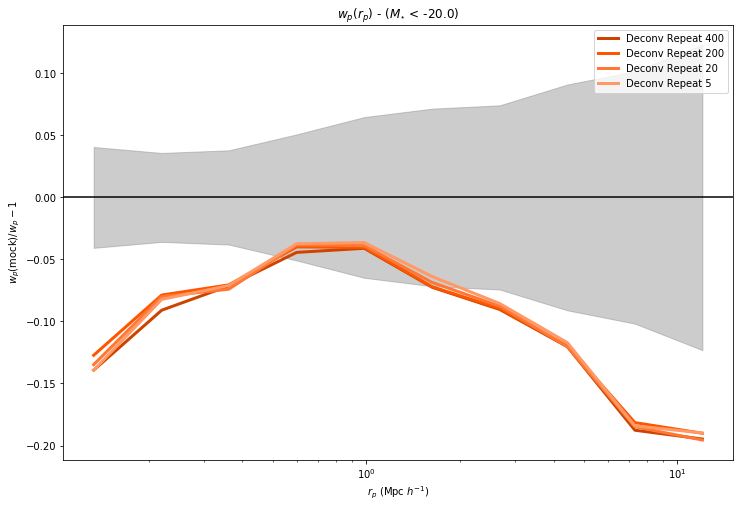

In [5]:
custom_blues_complement = ["#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300","#662200"]
wp_tests400 = np.loadtxt(wp_save_path+'1_150000100000_wp.txt')
wp_tests200 = np.loadtxt(wp_save_path+'2_150000100000_wp.txt')
wp_tests20 = np.loadtxt(wp_save_path+'3_150000100000_wp.txt')
wp_tests5 = np.loadtxt(wp_save_path+'4_150000100000_wp.txt')
params = np.loadtxt(wp_save_path + '1_150000100000_p.txt')
print(params)
plt.figure(figsize=(12,8))
plt.plot(wp_21[:,0],wp_tests400[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[3])
plt.plot(wp_21[:,0],wp_tests200[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[2])
plt.plot(wp_21[:,0],wp_tests20[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[1])
plt.plot(wp_21[:,0],wp_tests5[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[0])
plt.fill_between(wp_21[:,0],-np.sqrt(wp_21_var)/wp_21[:,1],np.sqrt(wp_21_var)/wp_21[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[0]))
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.legend(['Deconv Repeat 400','Deconv Repeat 200','Deconv Repeat 20','Deconv Repeat 5'])
plt.xscale('log')
plt.axhline(0,c='k')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(wp_20[:,0],wp_tests400[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[3])
plt.plot(wp_20[:,0],wp_tests200[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[2])
plt.plot(wp_20[:,0],wp_tests20[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[1])
plt.plot(wp_20[:,0],wp_tests5[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[0])
plt.fill_between(wp_20[:,0],-np.sqrt(wp_20_var)/wp_20[:,1],np.sqrt(wp_20_var)/wp_20[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[1]))
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.legend(['Deconv Repeat 400','Deconv Repeat 200','Deconv Repeat 20','Deconv Repeat 5'])
plt.axhline(0,c='k')
plt.show()

### Test if we can use random trees to prune the catalogs ahead of time.

In [6]:
lf_list = [lf_20,lf_20]
wp_data_list = [wp_21[:,1],wp_20[:,1]]
wp_cov_list = [wp_21_cov,wp_20_cov]
deconv_repeat = 20
wp_save_path = '/u/ki/swagnerc/abundance_matching/wp_results/wp'
like_class_none = AMLikelihood(lf_list,halos,'vmax',box_size,r_p_data,mag_cuts,wp_data_list,wp_cov_list,pimax,
                               nthreads,deconv_repeat,wp_save_path+'1',n_k_tree_cut=None)
like_class_alittle = AMLikelihood(lf_list,halos,'vmax',box_size,r_p_data,mag_cuts,wp_data_list,wp_cov_list,pimax,
                                  nthreads,deconv_repeat,wp_save_path+'2',n_k_tree_cut=int(len(halos)*0.001))
like_class_some = AMLikelihood(lf_list,halos,'vmax',box_size,r_p_data,mag_cuts,wp_data_list,wp_cov_list,pimax,
                               nthreads,deconv_repeat,wp_save_path+'3',n_k_tree_cut=int(len(halos)*0.01))
like_class_alot = AMLikelihood(lf_list,halos,'vmax',box_size,r_p_data,mag_cuts,wp_data_list,wp_cov_list,pimax,
                               nthreads, deconv_repeat,wp_save_path+'4',n_k_tree_cut=int(len(halos)*0.1))

In [7]:
scatter = 0.15
mu_cut = 0.1
import time
start = time.time()
print('Scatter %.2f, mu_cut %.2f, ll %.5f'%(scatter,mu_cut,like_class_none.log_likelihood([scatter,mu_cut],
                                                                                         verbose=False)))
print(time.time()-start)

start = time.time()
print('Scatter %.2f, mu_cut %.2f, ll %.5f'%(scatter,mu_cut,like_class_alittle.log_likelihood([scatter,mu_cut],
                                                                                         verbose=False)))
print(time.time()-start)

start = time.time()
print('Scatter %.2f, mu_cut %.2f, ll %.5f'%(scatter,mu_cut,like_class_some.log_likelihood([scatter,mu_cut],
                                                                                         verbose=False)))
print(time.time()-start)

start = time.time()
print('Scatter %.2f, mu_cut %.2f, ll %.5f'%(scatter,mu_cut,like_class_alot.log_likelihood([scatter,mu_cut],
                                                                                         verbose=False)))
print(time.time()-start)

Scatter 0.15, mu_cut 0.10, ll -25.08135
20.70896315574646
Scatter 0.15, mu_cut 0.10, ll -30.07781
24.659168004989624
Scatter 0.15, mu_cut 0.10, ll -31.09913
18.285829544067383
Scatter 0.15, mu_cut 0.10, ll -59.69041
29.636909008026123


[0.15 0.1 ]


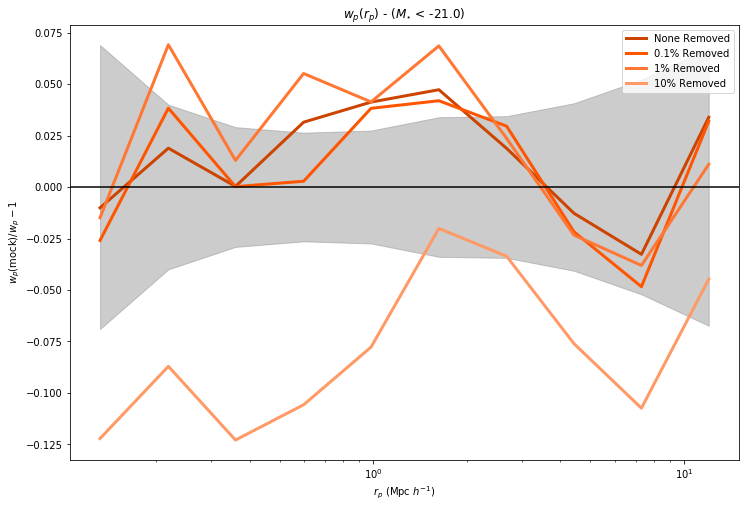

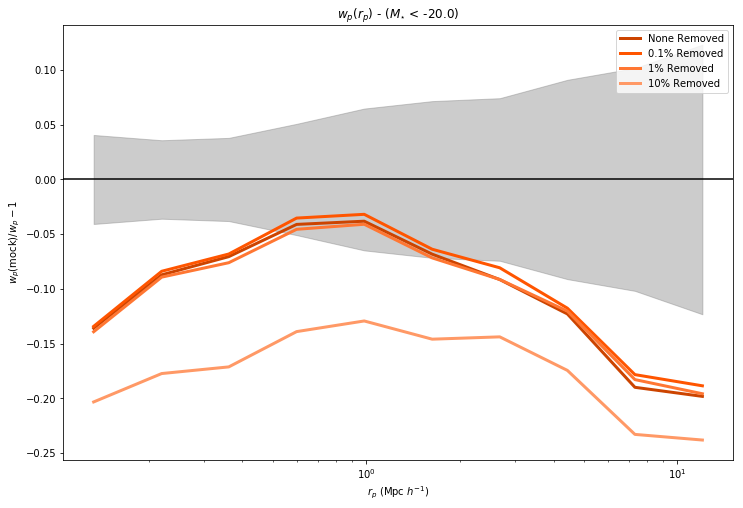

In [8]:
custom_blues_complement = ["#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300","#662200"]
wp_tests_none = np.loadtxt(wp_save_path+'1_150000100000_wp.txt')
wp_tests_alittle = np.loadtxt(wp_save_path+'2_150000100000_wp.txt')
wp_tests_some = np.loadtxt(wp_save_path+'3_150000100000_wp.txt')
wp_tests_alot = np.loadtxt(wp_save_path+'4_150000100000_wp.txt')
params = np.loadtxt(wp_save_path + '_150000100000_p.txt')
print(params)
plt.figure(figsize=(12,8))
plt.plot(wp_21[:,0],wp_tests_none[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[3])
plt.plot(wp_21[:,0],wp_tests_alittle[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[2])
plt.plot(wp_21[:,0],wp_tests_some[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[1])
plt.plot(wp_21[:,0],wp_tests_alot[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[0])
plt.fill_between(wp_21[:,0],-np.sqrt(wp_21_var)/wp_21[:,1],np.sqrt(wp_21_var)/wp_21[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[0]))
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.legend(['None Removed','0.1% Removed','1% Removed','10% Removed'])
plt.xscale('log')
plt.axhline(0,c='k')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(wp_20[:,0],wp_tests_none[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[3])
plt.plot(wp_20[:,0],wp_tests_alittle[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[2])
plt.plot(wp_20[:,0],wp_tests_some[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[1])
plt.plot(wp_20[:,0],wp_tests_alot[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[0])
plt.fill_between(wp_20[:,0],-np.sqrt(wp_20_var)/wp_20[:,1],np.sqrt(wp_20_var)/wp_20[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[1]))
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.legend(['None Removed','0.1% Removed','1% Removed','10% Removed'])
plt.axhline(0,c='k')
plt.show()

### Undertand why certain parameter combinations are kept

In [19]:
lf_list = [lf_20,lf_20]
wp_data_list = [wp_21[:,1],wp_20[:,1]]
wp_cov_list = [wp_21_cov,wp_20_cov]
deconv_repeat = 20
wp_save_path = '/u/ki/swagnerc/abundance_matching/wp_results/'

params1 = np.loadtxt(wp_save_path + 'wp_992002896540_p.txt')
params2 = np.loadtxt(wp_save_path + 'wp_11531833748_p.txt')

print(params1)
print(params2)

wp_params1 = np.loadtxt(wp_save_path+'wp_992002896540_wp.txt')
wp_params2 = np.loadtxt(wp_save_path+'wp_11531833748_wp.txt')

[0.99200211 0.89654099]
[0.11531848 0.03374853]


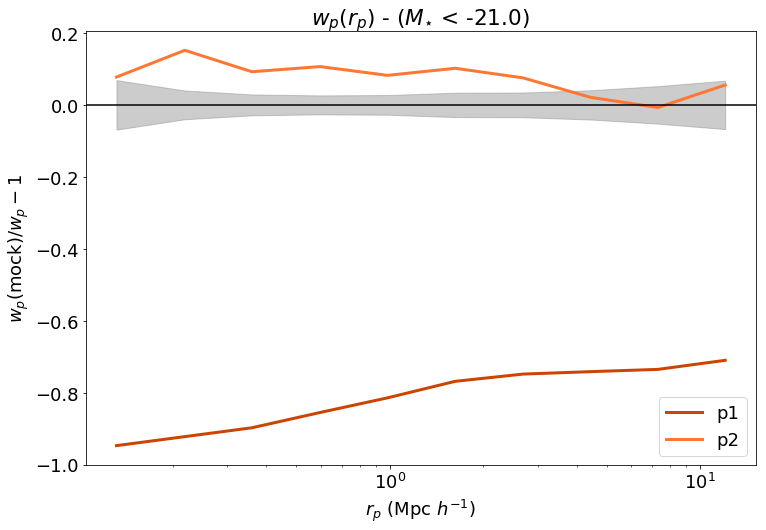

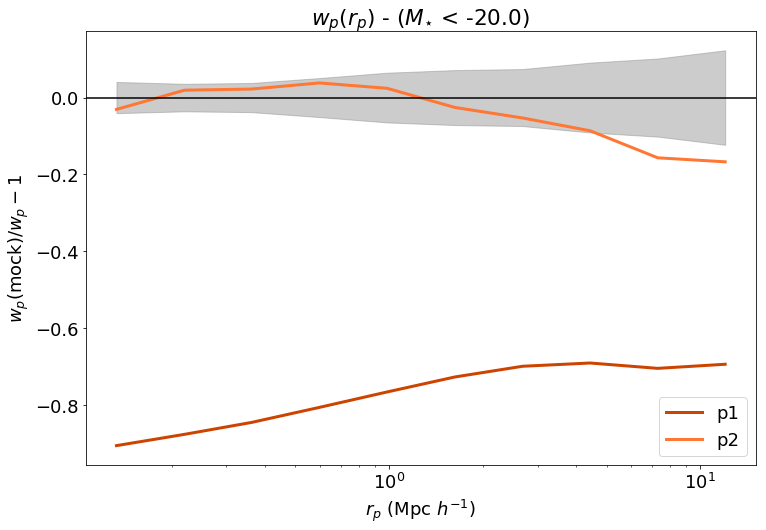

In [20]:
custom_blues_complement = ["#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300","#662200"]

plt.figure(figsize=(12,8))
plt.plot(wp_21[:,0],wp_params1[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[3])
plt.plot(wp_21[:,0],wp_params2[0]/wp_21[:,1]-1,lw=3,c=custom_blues_complement[1])
plt.fill_between(wp_21[:,0],-np.sqrt(wp_21_var)/wp_21[:,1],np.sqrt(wp_21_var)/wp_21[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[0]))
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.legend(['p1','p2'])
plt.xscale('log')
plt.axhline(0,c='k')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(wp_20[:,0],wp_params1[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[3])
plt.plot(wp_20[:,0],wp_params2[1]/wp_20[:,1]-1,lw=3,c=custom_blues_complement[1])
plt.fill_between(wp_20[:,0],-np.sqrt(wp_20_var)/wp_20[:,1],np.sqrt(wp_20_var)/wp_20[:,1],alpha=0.4,color='grey')
plt.title('$w_p(r_p)$ - ($M_{\star}$ < %.1f)'%(mag_cuts[1]))
plt.ylabel('$w_p (\mathrm{mock}) / w_p - 1$')
plt.xlabel('$r_p \ (\mathrm{Mpc } \ h^{-1})$')
# plt.ylim([-1,1])
plt.xscale('log')
plt.legend(['p1','p2'])
plt.axhline(0,c='k')
plt.show()

In [10]:
from AbundanceMatching import *
import emcee, pandas, time
from os.path import exists
import numpy as np
import Corrfunc
from Corrfunc.theory import wp
from astropy.io import fits
from galaxy_statistics import AMLikelihood
from tqdm import tqdm
from multiprocessing import Pool

# First load all of the data we'll use for the MCMC sampling

data_path = '/u/ki/rmredd/data/'
# Luminosity function
# lf_21 = np.loadtxt(data_path + 'lf/tinker/lf_jt_21.dat')
lf_20 = np.loadtxt(data_path + 'lf/tinker/lf_jt_20.dat')
lf_18 = np.loadtxt(data_path + 'lf/tinker/lf_jt_18.dat')
# lf_21 = lf_21[lf_21[:,1]>0,:]
lf_20 = lf_20[lf_20[:,1]>0,:]
lf_18 = lf_18[lf_18[:,1]>0,:]

wp_path = '/u/ki/rmredd/data/corr_wp/tinker_sdss_wp/'
wp_20 = np.loadtxt(wp_path + 'wp_20.dat')
wp_20_cov_temp = np.loadtxt(wp_path + 'wp_covar_20.dat')
wp_20_cov = np.zeros((len(wp_20),len(wp_20)))
for wp_tup in wp_20_cov_temp:
	wp_20_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
	wp_20_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
	
wp_18 = np.loadtxt(wp_path + 'wp_18.dat')
wp_18_cov_temp = np.loadtxt(wp_path + 'wp_covar_18.dat')
wp_18_cov = np.zeros((len(wp_18),len(wp_18)))
for wp_tup in wp_18_cov_temp:
	wp_18_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
	wp_18_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
	
wp_21 = np.loadtxt(wp_path + 'wp_21.dat')
wp_21_cov_temp = np.loadtxt(wp_path + 'wp_covar_21.dat')
wp_21_cov = np.zeros((len(wp_21),len(wp_21)))
for wp_tup in wp_21_cov_temp:
	wp_21_cov[int(wp_tup[0])-1,int(wp_tup[1])-1] = wp_tup[2]
	wp_21_cov[int(wp_tup[1])-1,int(wp_tup[0])-1] = wp_tup[2]
	
r_cutoff = 15

wp_20_cov=wp_20_cov[wp_20[:,0]<r_cutoff,:]
wp_20_cov=wp_20_cov[:,wp_20[:,0]<r_cutoff]
wp_20_var = np.diag(wp_20_cov)
wp_20 = wp_20[wp_20[:,0]<r_cutoff]

wp_18_cov=wp_18_cov[wp_18[:,0]<r_cutoff,:]
wp_18_cov=wp_18_cov[:,wp_18[:,0]<r_cutoff]
wp_18_var = np.diag(wp_18_cov)
wp_18 = wp_18[wp_18[:,0]<r_cutoff]

wp_21_cov=wp_21_cov[wp_21[:,0]<r_cutoff,:]
wp_21_cov=wp_21_cov[:,wp_21[:,0]<r_cutoff]
wp_21_var = np.diag(wp_21_cov)
wp_21 = wp_21[wp_21[:,0]<r_cutoff]

box_size = 400
pimax = 40.0
deconv_repeat = 200
mag_cuts=[-21.0,-20.0]
# Use lf_20 twice since we don't have an lf_21
lf_list = [lf_20,lf_20]

# Halos from n body sim
halo_path = '/nfs/slac/des/fs1/g/sims/jderose/BCCSims/c400-2048/'
halos = np.array(fits.open(halo_path + 'hlist_1.00000.list.fits')[1].data)
r_p_data = wp_20[:,0]
wp_data_list = [wp_21[:,1],wp_20[:,1]]
wp_cov_list = [wp_21_cov,wp_20_cov]
nthreads = 1

wp_save_path = '/u/ki/swagnerc/abundance_matching/wp_results/wp'

af_criteria = 'vmax'

like_class = AMLikelihood(lf_list,halos,af_criteria,box_size,r_p_data,mag_cuts,
	wp_data_list,wp_cov_list,pimax,nthreads,deconv_repeat,wp_save_path)

# Test speed of a single function call
like_class.wp_save_path = '/u/ki/swagnerc/abundance_matching/wp_results/timing'
start = time.time()
like_class.log_likelihood([0.1,0.1])
print('One evaluation takes %.2f seconds'%(time.time()-start))

[-3.19485087 39.96707273  9.75578924 10.73311548  8.78001613  7.92653793
  4.18927885  1.1290235  -0.09983216  0.83321299]
[-59.72226374 -23.78467871 -13.29086535  -4.84080745  -2.86454202
  -3.83501684  -3.46610944  -3.43215373  -3.77769058  -2.59489372]
One evaluation takes 21.86 seconds


In [11]:
like1, wp_res1 = like_class.log_likelihood([0.2,0.1],verbose=True)

In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,27,10.  Time taken =   0.019 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.105 secs


[-116.36162168  -48.92241198  -20.07329665  -12.62892269   -5.09735495
   -3.32137208   -3.51521828   -3.61274415   -3.06147856   -0.95041041]


In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,27,10.  Time taken =   0.093 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.......

[-61.68883885 -28.3285771  -14.94887882  -6.71012394  -4.30456697
  -4.58310367  -4.00468144  -3.83729528  -4.01550055  -2.64296904]


..100% done. Time taken =  2.686 secs


In [12]:
like2, wp_res2 = like_class.log_likelihood([0.9,0.5],verbose=True)

In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,27,10.  Time taken =   0.114 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.017 secs


[-754.80393027 -446.31211743 -278.00083009 -153.87507184  -91.12913647
  -54.33095562  -37.74789523  -26.56870116  -17.49341426  -10.02547024]


In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,27,10.  Time taken =   0.429 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........

[-410.13540519 -261.79034244 -174.28711848 -110.05582712  -69.0849032
  -44.21160328  -29.43401141  -20.36537955  -14.600346     -9.17204466]


.100% done. Time taken = 16.256 secs


In [13]:
print(like1,like2)

-28.428390712154915 -1691.270074968811
